#Error analisis

In [1]:
import pandas as pd
file_name = "results.csv"
results = pd.read_csv(file_name, header=0, sep=',')
results.p = results.p.apply(lambda a: round(a, 2))

In [2]:
results.head()


,Unnamed: 0,Unnamed: 0.1,label,text,prep_text,p
0,13680,58770,1,Let's face it -- nothing short of a gorilla su...,let's face it - - nothing short of a gorilla s...,0.27
1,71716,22099,1,"A modest and accessible Iranian film, softer t...","a modest and accessible iranian film , softer ...",1.00
2,2273,46279,1,I saw the movie and really could not stop my t...,i saw the movie and really could not stop my t...,1.00
3,25816,60370,0,"Despite a rich premise, Just Friends ultimatel...","despite a rich premise , just friends ultimate...",0.01
4,22921,9272,1,"Shot in astonishingly elaborate long takes, th...","shot in astonishingly elaborate long takes , t...",1.00


In [20]:
errors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2375 entries, 37 to 14891
Data columns (total 6 columns):
Unnamed: 0      2375 non-null int64
Unnamed: 0.1    2375 non-null int64
label           2375 non-null int64
text            2375 non-null object
prep_text       2375 non-null object
p               2375 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 129.9+ KB


In [4]:
sigmoid_border = 0.5
false_positives_errors = results[((results.label == 0) & (results.p >= 1 - sigmoid_border))]
false_negatives_errors = results[((results.label == 1) & (results.p <= sigmoid_border))]
errors = pd.concat([false_positives_errors, false_negatives_errors])

In [5]:
%matplotlib inline
from matplotlib import pylab as plt
import numpy as np

In [6]:
from collections import Counter
def plot_error( frame ):
    counts=sorted(Counter(frame.p).items())
    plt.plot([x[0] for x in counts], [y[1] for y in counts])
    plt.show()

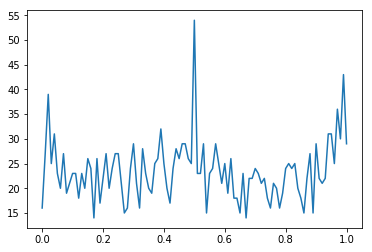

In [7]:
plot_error(errors)

In [8]:
false_negatives_errors.sort(['p'], ascending=[1]).to_csv("false_negatives_errors.csv")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


#Load LSTM Model

In [9]:
MODEL_NAME = "models/lstm_word2vec"
TEST_DATASET = "data/test_imdb.csv"

TOKENIZER_NAME = "models/lstm_word2vec_tokenizer"

import nltk
import numpy
import pickle
numpy.random.seed(42)

from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from itertools import chain
from collections import Counter


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import model_from_json

pd.options.display.max_colwidth = -1

MAX_NB_WORDS = 20000
MAX_SEQUENCE_LENGTH = 70

from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()

negatives = {
    "didn't": "didn_`_t",
    "couldn't": "couldn_`_t",
    "don't": "don_`_t",
    "wouldn't": "wouldn_`_t",
    "doesn't": "doesn_`_t",
    "wasn't": "wasn_`_t",
    "weren't": "weren_`_t",
    "shouldn't":"shouldn_`_t",
    "isn't": "isn_`_t",
    "aren't": "aren_`_t",
}

def preprocess(text):
    text = text.lower()
    text = text.replace('<br />', ' ')
    text = ' '.join(tweet_tokenizer.tokenize(text))
    for k, v in negatives.items():
        text = text.replace(k, v)
    return text

 #load tokenizer
pkl_file = open(TOKENIZER_NAME, 'rb')
tokenizer = pickle.load(pkl_file)
pkl_file.close()

# load json and create model
json_file = open(MODEL_NAME + '.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights(MODEL_NAME + ".hdf5")
metrics=['accuracy', 'fmeasure', 'precision', 'recall']
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
print("Loaded '%s' model from disk" % MODEL_NAME)

def padding(text):
    return pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_SEQUENCE_LENGTH)

def lstm_predict(text):
    return loaded_model.predict(padding(preprocess(text)))[0][0]

Using TensorFlow backend.


Loaded 'models/lstm_word2vec' model from disk


In [10]:
lstm_predict("at least")

0.40378448

In [11]:
from nltk.corpus import sentiwordnet as swn
pos = {
    "NN": "n",
    "JJ": "a",
    "VB": "v",
    "RB": "r",
    "NNS": "n",
    "JJS": "a",
}

In [27]:
get_senti_scores('good it\'s one that every self respecting animation fan')

,word,obj_score,neg_score,pos_score,lstm
0,good,0.25,0.0,0.75,0.812808
1,one,1.00,0.0,0.00,0.509497
2,every,1.00,0.0,0.00,0.478353
3,self,1.00,0.0,0.00,0.489059
4,respecting,0.50,0.0,0.50,0.462395
5,animation,1.00,0.0,0.00,0.632826
6,fan,1.00,0.0,0.00,0.229211


In [14]:
def get_senti_scores(sentence):
    words = sentence.split(' ')
    pos_words = nltk.pos_tag(words)
    result = pd.DataFrame(columns=(u'word', u'obj_score', u'neg_score', u'pos_score', u'lstm'))
    for pos_word in pos_words:
        santi_word_net_p_list = list(swn.senti_synsets(pos_word[0], pos=pos.get(pos_word[1])))
        if len(santi_word_net_p_list) > 0:
            santi_word_net_p = santi_word_net_p_list[0]
            lstm_p = lstm_predict(pos_word[0])
            result = result.append({u'word':pos_word[0], u'obj_score':santi_word_net_p.obj_score(),\
                       u'neg_score':santi_word_net_p.neg_score(), u'pos_score': santi_word_net_p.pos_score(),\
                       u'lstm' : lstm_p}, ignore_index=True)
    return result;

In [16]:
get_senti_scores(errors.prep_text[0])

,word,obj_score,neg_score,pos_score,lstm
0,face,1.000,0.000,0.000,0.637985
1,it,1.000,0.000,0.000,0.507447
2,nothing,0.500,0.250,0.250,0.149479
3,short,1.000,0.000,0.000,0.264346
4,a,1.000,0.000,0.000,0.509308
5,gorilla,1.000,0.000,0.000,0.493451
6,suit,1.000,0.000,0.000,0.458240
7,can,1.000,0.000,0.000,0.584453
8,make,1.000,0.000,0.000,0.516200
9,peter,1.000,0.000,0.000,0.485930


In [30]:
%%time
senti_results = pd.DataFrame(columns=(u'word', u'obj_score', u'neg_score', u'pos_score', u'lstm'))
senti_results = pd.DataFrame(columns=(u'word', u'obj_score', u'neg_score', u'pos_score', u'lstm'))

for index, sentence in enumerate(errors.prep_text):
    if(index%10 == 0):
        print(index)   
    senti_results = pd.concat([senti_results, get_senti_scores(sentence)])

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650


KeyboardInterrupt: 

In [33]:
senti_results.drop_duplicates(subset='word', keep ='first', inplace = True)


In [38]:
filtered_senti_results = senti_results[((senti_results.neg_score != 0) | (senti_results.pos_score != 0))]
print(filtered_senti_results)

              word  obj_score  neg_score  pos_score      lstm
0    definitely     0.750      0.000      0.250      0.650141
1    shallower      0.875      0.125      0.000      0.509308
5    too            0.625      0.250      0.125      0.318227
9    is             0.625      0.125      0.250      0.470941
1    had            0.750      0.000      0.250      0.405140
2    high           0.625      0.250      0.125      0.685762
3    hopes          0.625      0.125      0.250      0.847740
6    enjoyed        0.625      0.000      0.375      0.395008
10   however        0.375      0.500      0.125      0.571394
14   have           0.750      0.000      0.250      0.421306
15   understood     0.625      0.000      0.375      0.290305
19   already        0.875      0.000      0.125      0.983647
25   noble          0.500      0.000      0.500      0.585166
28   despair        0.750      0.250      0.000      0.476882
31   break          0.625      0.125      0.250      0.723687
33   ove

In [ ]:
filtered_senti_results.to_csv("santiwordnet_vs_", header=0, sep=',')